In [19]:
# Imports
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import time
from matplotlib import pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay

In [20]:
# Load and display the dataset
df = pd.read_csv('Airline_Delay_Cause.csv')
print(df.head())

# Drop rows with missing key columns needed for target/label creation
df = df.dropna(subset=["arr_delay", "arr_flights", "arr_del15"]).reset_index(drop=True)

# Remove rows where arr_flights is zero to avoid division by zero
df = df[df["arr_flights"] > 0].reset_index(drop=True)

# Create delay_rate feature (fraction of flights delayed >=15 minutes)
df["delay_rate"] = df["arr_del15"] / df["arr_flights"]

print("Dataset shape after cleaning:", df.shape)
print(df.head())

# One-hot encode categorical and object features
cat_cols = df.select_dtypes(include=["object", "category"]).columns
print("\nCategorical columns:", list(cat_cols))

df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=True)
df_encoded.head()

# Create target variables 
# Classification target: high vs low delay_rate
delay_rate_threshold = 0.25   # 25% of flights delayed >= 15 minutes
df_encoded["High_Delay"] = (df["delay_rate"] > delay_rate_threshold).astype(int)

X_cls = df_encoded.drop("High_Delay", axis=1)
y_cls = df_encoded["High_Delay"]

   year  month carrier       carrier_name airport  arr_flights  arr_del15  \
0  2023      8      9E  Endeavor Air Inc.     ABE         89.0       13.0   
1  2023      8      9E  Endeavor Air Inc.     ABY         62.0       10.0   
2  2023      8      9E  Endeavor Air Inc.     AEX         62.0       10.0   
3  2023      8      9E  Endeavor Air Inc.     AGS         66.0       12.0   
4  2023      8      9E  Endeavor Air Inc.     ALB         92.0       22.0   

   carrier_ct  weather_ct  nas_ct  security_ct  late_aircraft_ct  \
0        2.25        1.60    3.16          0.0              5.99   
1        1.97        0.04    0.57          0.0              7.42   
2        2.73        1.18    1.80          0.0              4.28   
3        3.69        2.27    4.47          0.0              1.57   
4        7.76        0.00    2.96          0.0             11.28   

   arr_cancelled  arr_diverted  arr_delay  carrier_delay  weather_delay  \
0            2.0           1.0     1375.0           7

In [21]:
# Split the data into train, validation, and test
# With stratification for classification
X_train_cls, X_temp_cls, y_train_cls, y_temp_cls = train_test_split(
    X_cls, y_cls, test_size=0.3, random_state=42, stratify=y_cls
)

X_val_cls, X_test_cls, y_val_cls, y_test_cls = train_test_split(
    X_temp_cls, y_temp_cls, test_size=(1/3), random_state=42, stratify=y_temp_cls
)

In [22]:
# Normalize the data
# Classification scaler
scaler_cls = StandardScaler()
X_train_cls_scaled = scaler_cls.fit_transform(X_train_cls)
X_val_cls_scaled = scaler_cls.transform(X_val_cls)
X_test_cls_scaled = scaler_cls.transform(X_test_cls)

In [23]:
# Logistic Regression Classification Model
log_reg = LogisticRegression(max_iter=1000, n_jobs=-1)

start_log = time.time()
log_reg.fit(X_train_cls_scaled, y_train_cls)
y_val_pred_log = log_reg.predict(X_val_cls_scaled)
y_test_pred_log = log_reg.predict(X_test_cls_scaled)
end_log = time.time()
time_log = end_log - start_log

acc_val_log = accuracy_score(y_val_cls, y_val_pred_log)
f1_val_log = f1_score(y_val_cls, y_val_pred_log)
rec_val_log = recall_score(y_val_cls, y_val_pred_log)
prec_val_log = precision_score(y_val_cls, y_val_pred_log)

acc_test_log = accuracy_score(y_test_cls, y_test_pred_log)
f1_test_log = f1_score(y_test_cls, y_test_pred_log)
rec_test_log = recall_score(y_test_cls, y_test_pred_log)
prec_test_log = precision_score(y_test_cls, y_test_pred_log)

print("\nLogistic Regression (Validation):")
print("Confusion Matrix:\n", confusion_matrix(y_val_cls, y_val_pred_log))
print("Accuracy: %.4f" % acc_val_log)
print("F1-score: %.4f" % f1_val_log)
print("Recall: %.4f" % rec_val_log)
print("Precision: %.4f" % prec_val_log)

print("\nLogistic Regression (Test):")
print("Confusion Matrix:\n", confusion_matrix(y_test_cls, y_test_pred_log))
print("Accuracy: %.4f" % acc_test_log)
print("F1-score: %.4f" % f1_test_log)
print("Recall: %.4f" % rec_test_log)
print("Precision: %.4f" % prec_test_log)

print("Training + prediction time (s): %.4f" % time_log)


Logistic Regression (Validation):
Confusion Matrix:
 [[26652    19]
 [   83  7490]]
Accuracy: 0.9970
F1-score: 0.9932
Recall: 0.9890
Precision: 0.9975

Logistic Regression (Test):
Confusion Matrix:
 [[13328     8]
 [   39  3748]]
Accuracy: 0.9973
F1-score: 0.9938
Recall: 0.9897
Precision: 0.9979
Training + prediction time (s): 4.2931


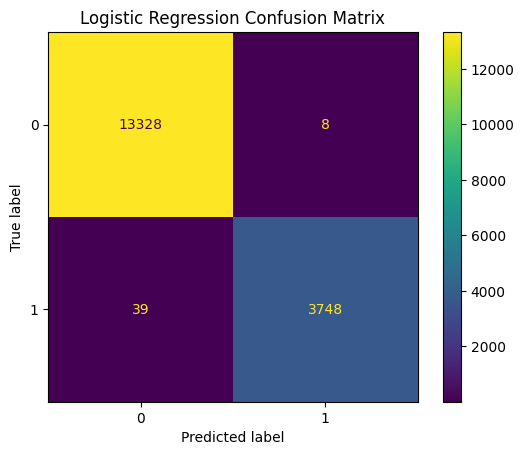

In [24]:
# Display confusion matrix for test set
ConfusionMatrixDisplay.from_predictions(y_test_cls, y_test_pred_log)
plt.title("Logistic Regression Confusion Matrix")
plt.show()

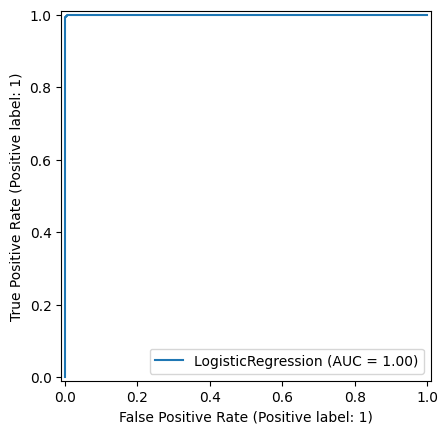

In [25]:
# Plot ROC Curve for Logistic Regression
RocCurveDisplay.from_estimator(log_reg, X_test_cls_scaled, y_test_cls)
plt.show()

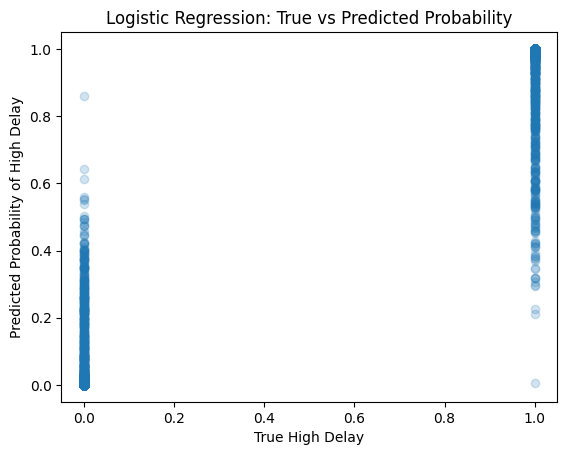

In [26]:
# Scatter plot of true vs predicted probabilities
y_probs = log_reg.predict_proba(X_test_cls_scaled)[:, 1]

plt.scatter(y_test_cls, y_probs, alpha=0.2)
plt.xlabel("True High Delay")
plt.ylabel("Predicted Probability of High Delay")
plt.title("Logistic Regression: True vs Predicted Probability")
plt.show()